# Set up the basic parameters

In [1]:
import os
import GWFrames
import Quaternions
from numpy import pi, array, argmin, abs
%pylab inline

DataDirectory = os.path.expanduser('~/Research/Data/SimAnnex/CatalogLinks/SXS:BBH:0104/Lev5')
WaveformFile = os.path.join(DataDirectory, 'rhOverM_Asymptotic_GeometricUnits_CoM.h5')
File1 = os.path.join(WaveformFile, 'Extrapolated_N2.dir')
File2 = os.path.join(WaveformFile, 'Extrapolated_N4.dir')

PhaseDifferencePlot = 'PhaseDifference.pdf'
AmplitudeDifferencePlot = 'AmplitudeDifference.pdf'

t1 = 1000.
t2 = 2000.
tmid = (t1+t2)/2.

Populating the interactive namespace from numpy and matplotlib


# Optionally, check that `GWFrames` is up to date

In particular, we check that the installed version of `GWFrames` that python finds is the most recent one in `GWFrames/master` [on github](https://github.com/MOBle/GWFrames).

In [ ]:
W = GWFrames.Waveform() # This is just an empty object so we can see what GWFrames is up to
LocalVer = W.HistoryStr().splitlines()[0].split()[-1]
RemoteVer = ! cd ~/Research/GWFrames_master && git fetch && git branch -r -v --no-abbrev | grep "^  origin/master" | awk '{print $2}'
if(LocalVer == RemoteVer[0]) :
    print('The current version of GWFrames you have installed is up to date with the remote master.')
else :
    print("""
WARNING: The remote master branch is different from the current version
         of GWFrames you have installed (according to python).  You might
         want to `git pull --rebase`, and then `make` in your `GWFrames`
         directory.  If you have done this quite recently and still see
         this message, python is probably finding the wrong version.""")

# Read in the data files

In [3]:
W1 = GWFrames.ReadFromNRAR(File1)
W2 = GWFrames.ReadFromNRAR(File2)

# Transform `W1` and `W2` to their corotating frames

In [4]:
W1.TransformToCorotatingFrame();
W2.TransformToCorotatingFrame();

Now we also align the frame of each waveform to set the $(2,2)$ mode to zero at time `tmid`, which restricts a certain rotational ambiguity in the corotating frame.

In [5]:
W1.AlignDecompositionFrameToModes(tmid);
W2.AlignDecompositionFrameToModes(tmid);

The condition on the $(2,2)$ mode is actually not strong enough to completely set the frame; there is still a possible rotation by $\pi$.  Here, we make sure that the frames are also aligned to their own decomposition bases in that sense.

In [6]:
xHat = Quaternions.Quaternion(0,1,0,0)
R1 = Quaternions.Squad(W1.Frame(), W1.T(), [tmid])[0]
R2 = Quaternions.Squad(W2.Frame(), W2.T(), [tmid])[0]
if((R1*xHat*R1.inverse()).dot(R2*xHat*R2.inverse())<0) : # If rotation is off by pi
    W2.RotateDecompositionBasis(GWFrames.exp(GWFrames.Quaternion(0,0,0,pi/2)))

# Align corotating frame of `W2` to corotating frame of `W1`

The frame of each waveform is now as close to being physically meaningful as possible.  So we can use the frames themselves to understand the physics.  On the other hand, coordinates are always meaningless, so we can see if the physics in the two waveforms can be made to look more similar by changing the coordinates.

The main remaining coordinate ambiguities are that we could shift the time coordinate by a constant, or we could rotate the spatial coordinates (by a constant rotation).  So here we adjust the time and rotation offsets by ensuring that the frames are as identical as possible over the span of time $(t_1, t_2)$.  [Remember that those frames now have physical meanings, so this alignment is actually meaningful.]

In [7]:
GWFrames.AlignWaveforms(W1, W2, t1, t2)

# Plot the overall rotational difference between the two waveforms

`PhiDelta` as calculated here is the right way to measure the phsae difference between two precessing waveforms, and works for nonprecessing systems too.  It is essentially the same thing that we used to call "phase difference" for nonprecessing systems (though smaller by a factor of 2).  But now that we discuss nonprecessing systems, it is necessary to keep track of all degrees of freedom.  The old "phase difference" cannot do this, but this measure does indeed reduce all degrees of freedom to one physically meaningful, geometrically invariant number.  I describe this quantity in [my paper that everyone should have read five times by now](http://arxiv.org/abs/1302.2919).

First, we interpolate everything onto the common subset of time steps:

In [8]:
T1 = W1.T()
R1 = W1.Frame()
T2 = W2.T()
Ti = max(T1[0],T2[0])
Tf = min(T1[-1],T2[-1])
R1 = W1.Frame()[(T1>=Ti) & (T1<=Tf)]
T1 = T1[(T1>=Ti) & (T1<=Tf)]
T2 = T2[(T2>=Ti) & (T2<=Tf)]
R2 = Quaternions.Squad(W2.Frame(), W2.T(), T1)
Imid = argmin(abs(T1-tmid))

Next, we actually get the difference and the angle between the two frames

In [9]:
RDelta = Quaternions.RDelta(R1, R2, Imid)

There may be sign ambiguities in the rotors themselves, because there are many ways to get the same rotor (exactly as there are many branches in the complex logarithm function).  Here, we just eliminate the ambiguity by stepping through, and make sure they have roughly the same sign between time steps.

In [10]:
RDelta = Quaternions.UnflipRotors(RDelta)

Though the "direction" of $R_\Delta$ does contain information, we can boil it down to a single number by just looking at the angle through which $R_\Delta$ rotates.

In [11]:
PhiDelta = Quaternions.angle(RDelta)

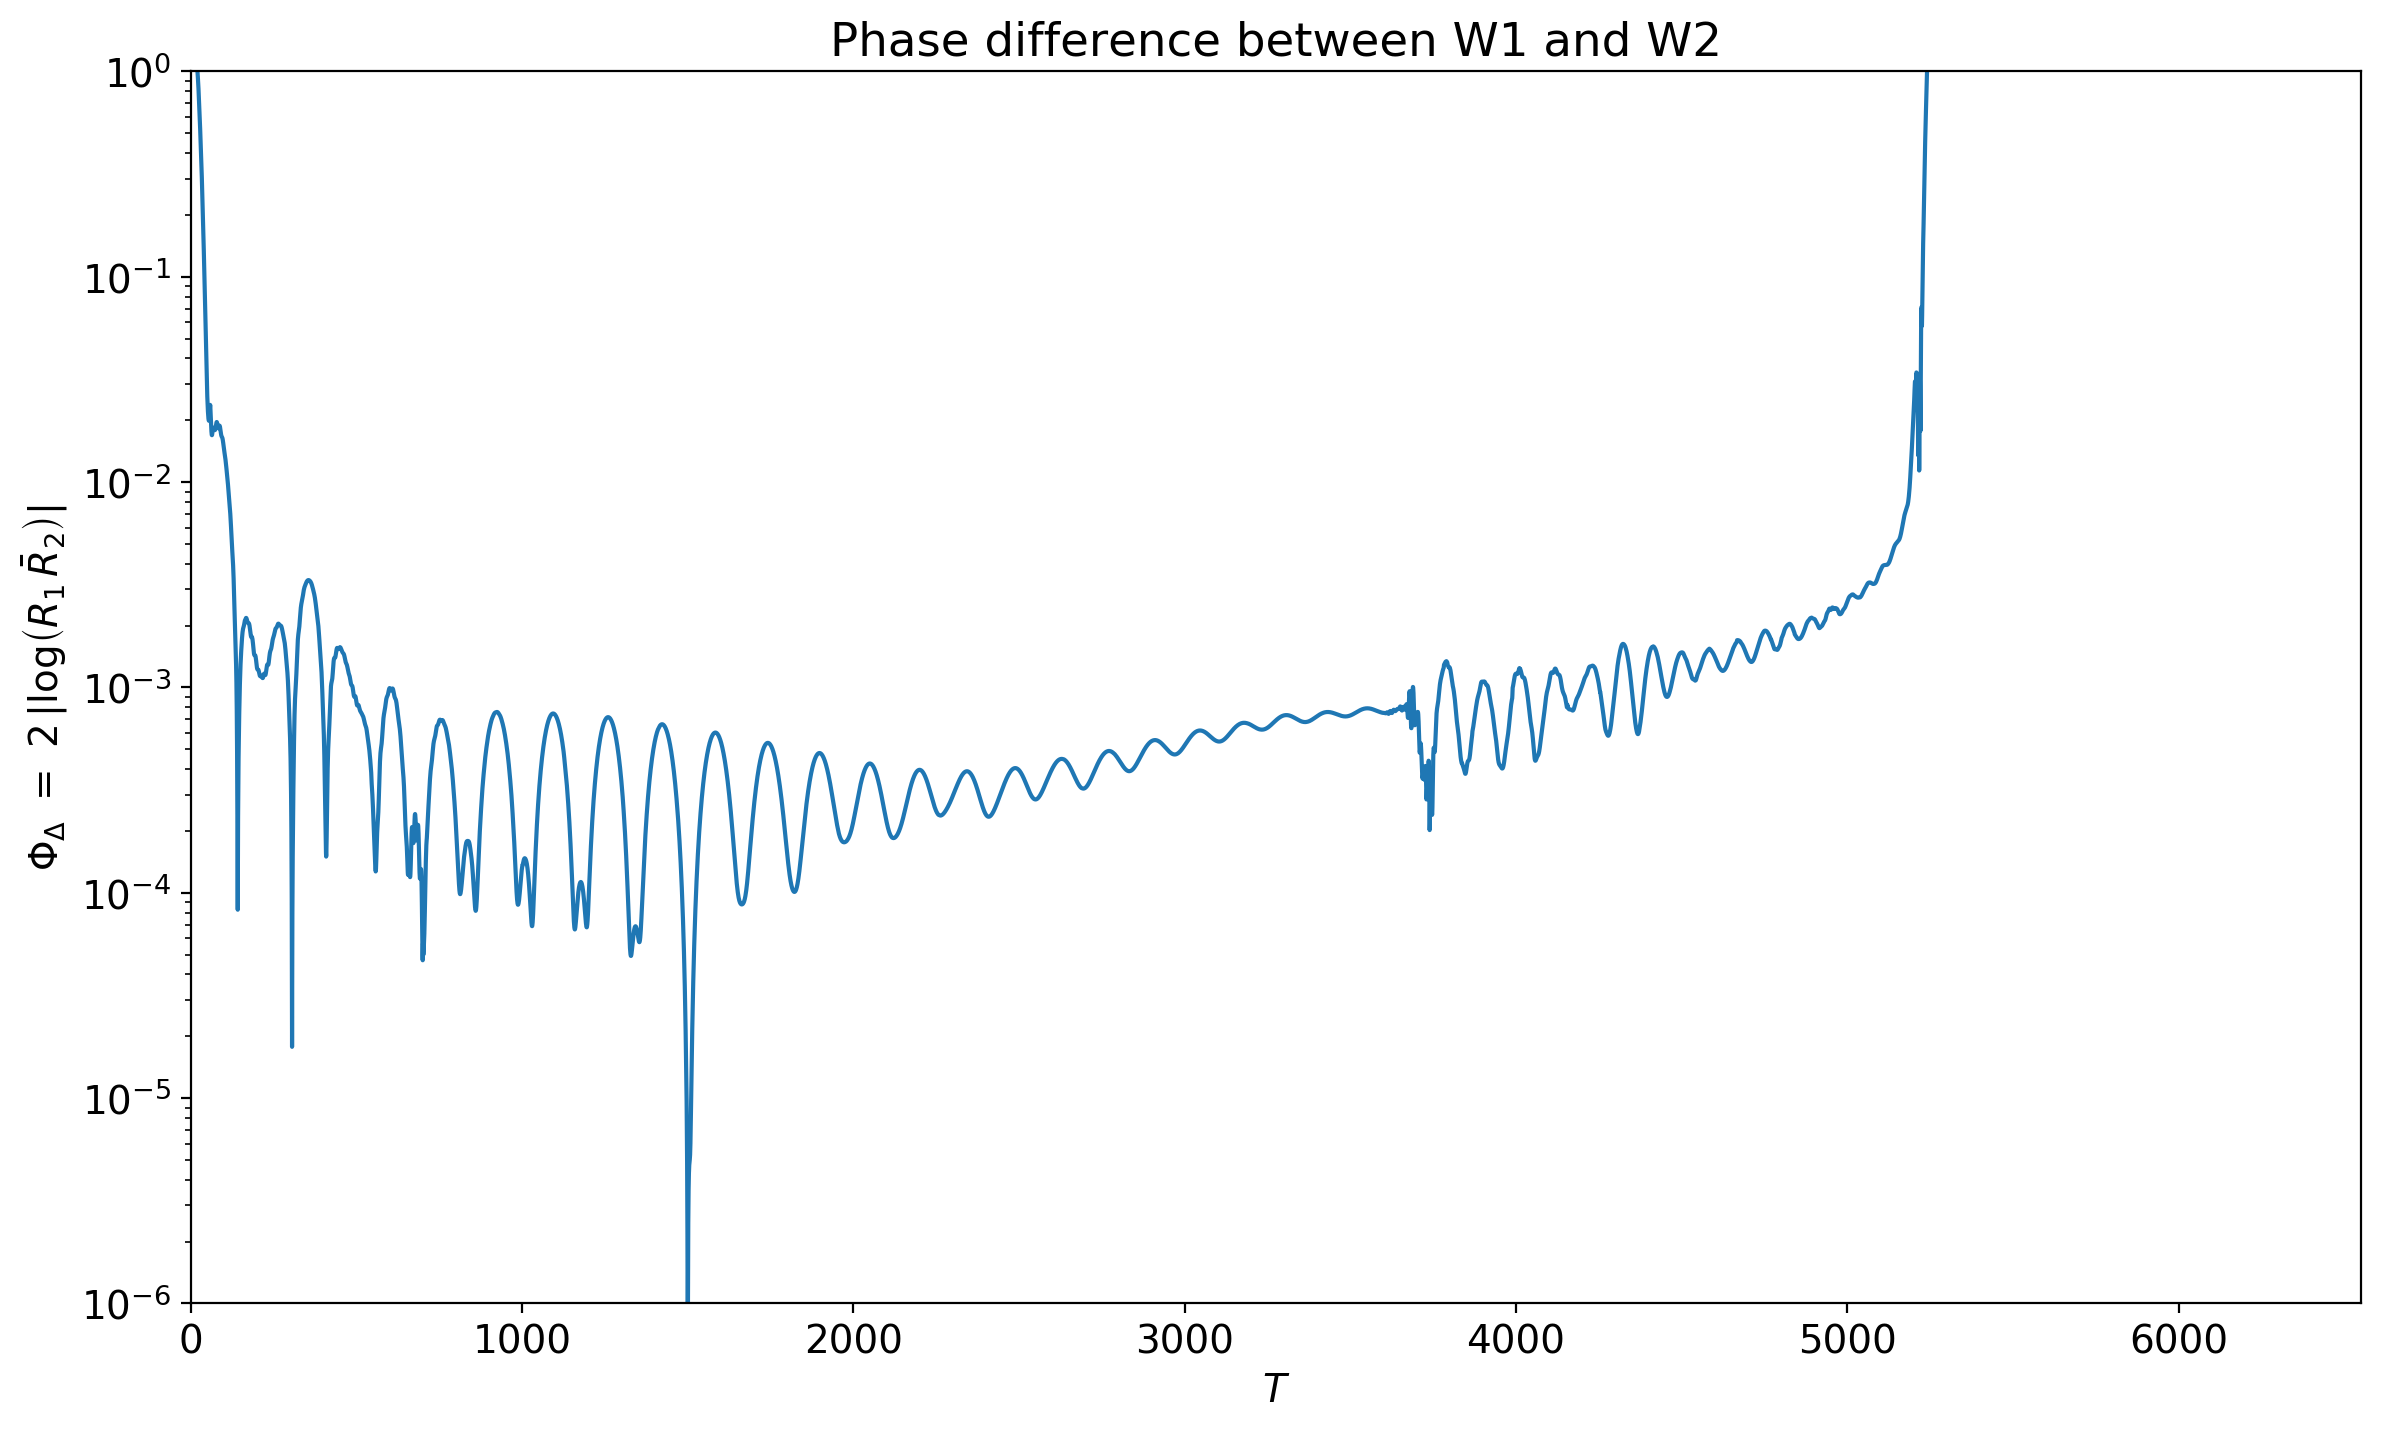

In [12]:
semilogy(T1, PhiDelta)
xlim((0,6550))
ylim((1e-6,1))
ylabel(r'$\Phi_{\Delta}\ =\ 2\, \left| \log \left( R_{1}\, \bar{R}_{2} \right) \right|$')
xlabel('$T$')
title('Phase difference between W1 and W2')

savefig(PhaseDifferencePlot);

# Plot the amplitude difference between the two waveforms

The amplitudes are most meaningful in the corotating frame.  Also, this is the frame in which the amplitudes look most like they would for nonprecessing systems.

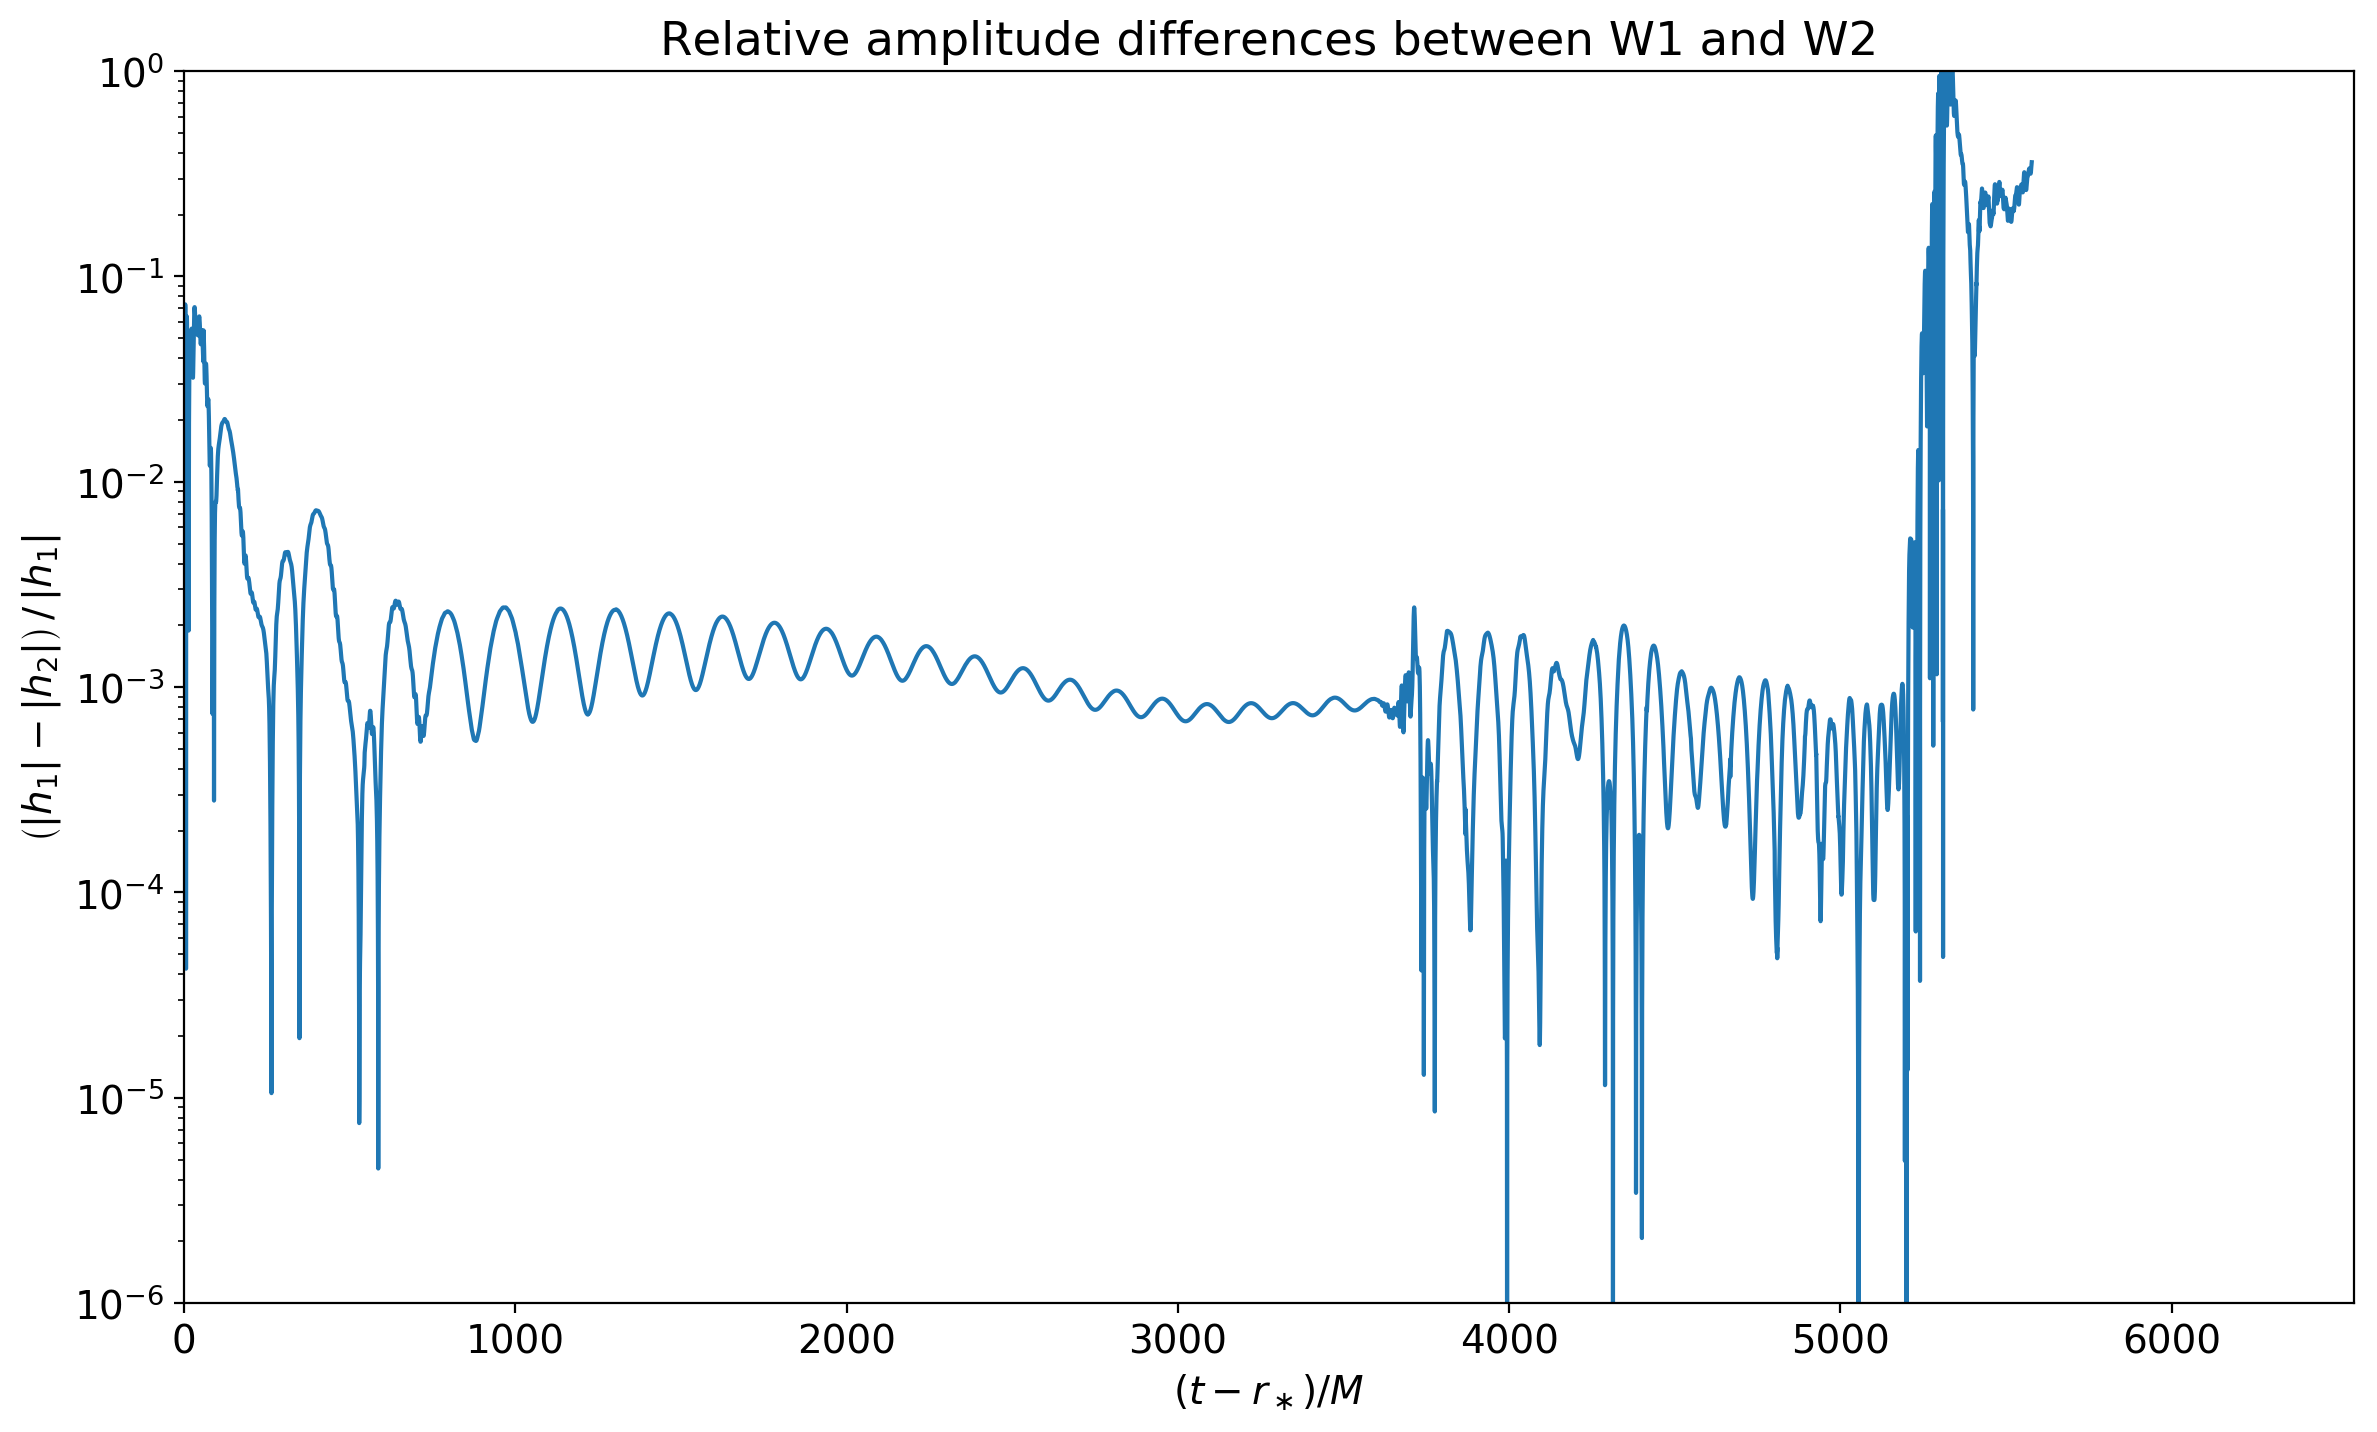

In [13]:
Abs1 = W1.Interpolate(T1).Abs(W1.FindModeIndex(2,2))
Abs2 = W2.Interpolate(T1).Abs(W2.FindModeIndex(2,2))

semilogy(T1, abs(Abs1-Abs2)/Abs1)
xlim((0,6550))
ylim((1e-6,1))
xlabel(r'$(t-r_\ast)/M$')
ylabel(r'$\left(|h_1|-|h_2|\right)\,/\,|h_1|$')
title('Relative amplitude differences between W1 and W2')

savefig(AmplitudeDifferencePlot);

# Hybridize

In [14]:
# First, pretend we only have the beginning of W1 and the end of W2
Wa = W1.SliceOfTimes(-np.inf, t2+1)
Wb = W1.SliceOfTimes(t1-1, np.inf)

In [15]:
# Now, just merge them
W_hybrid = Wa.Hybridize(Wb, t1, t2)

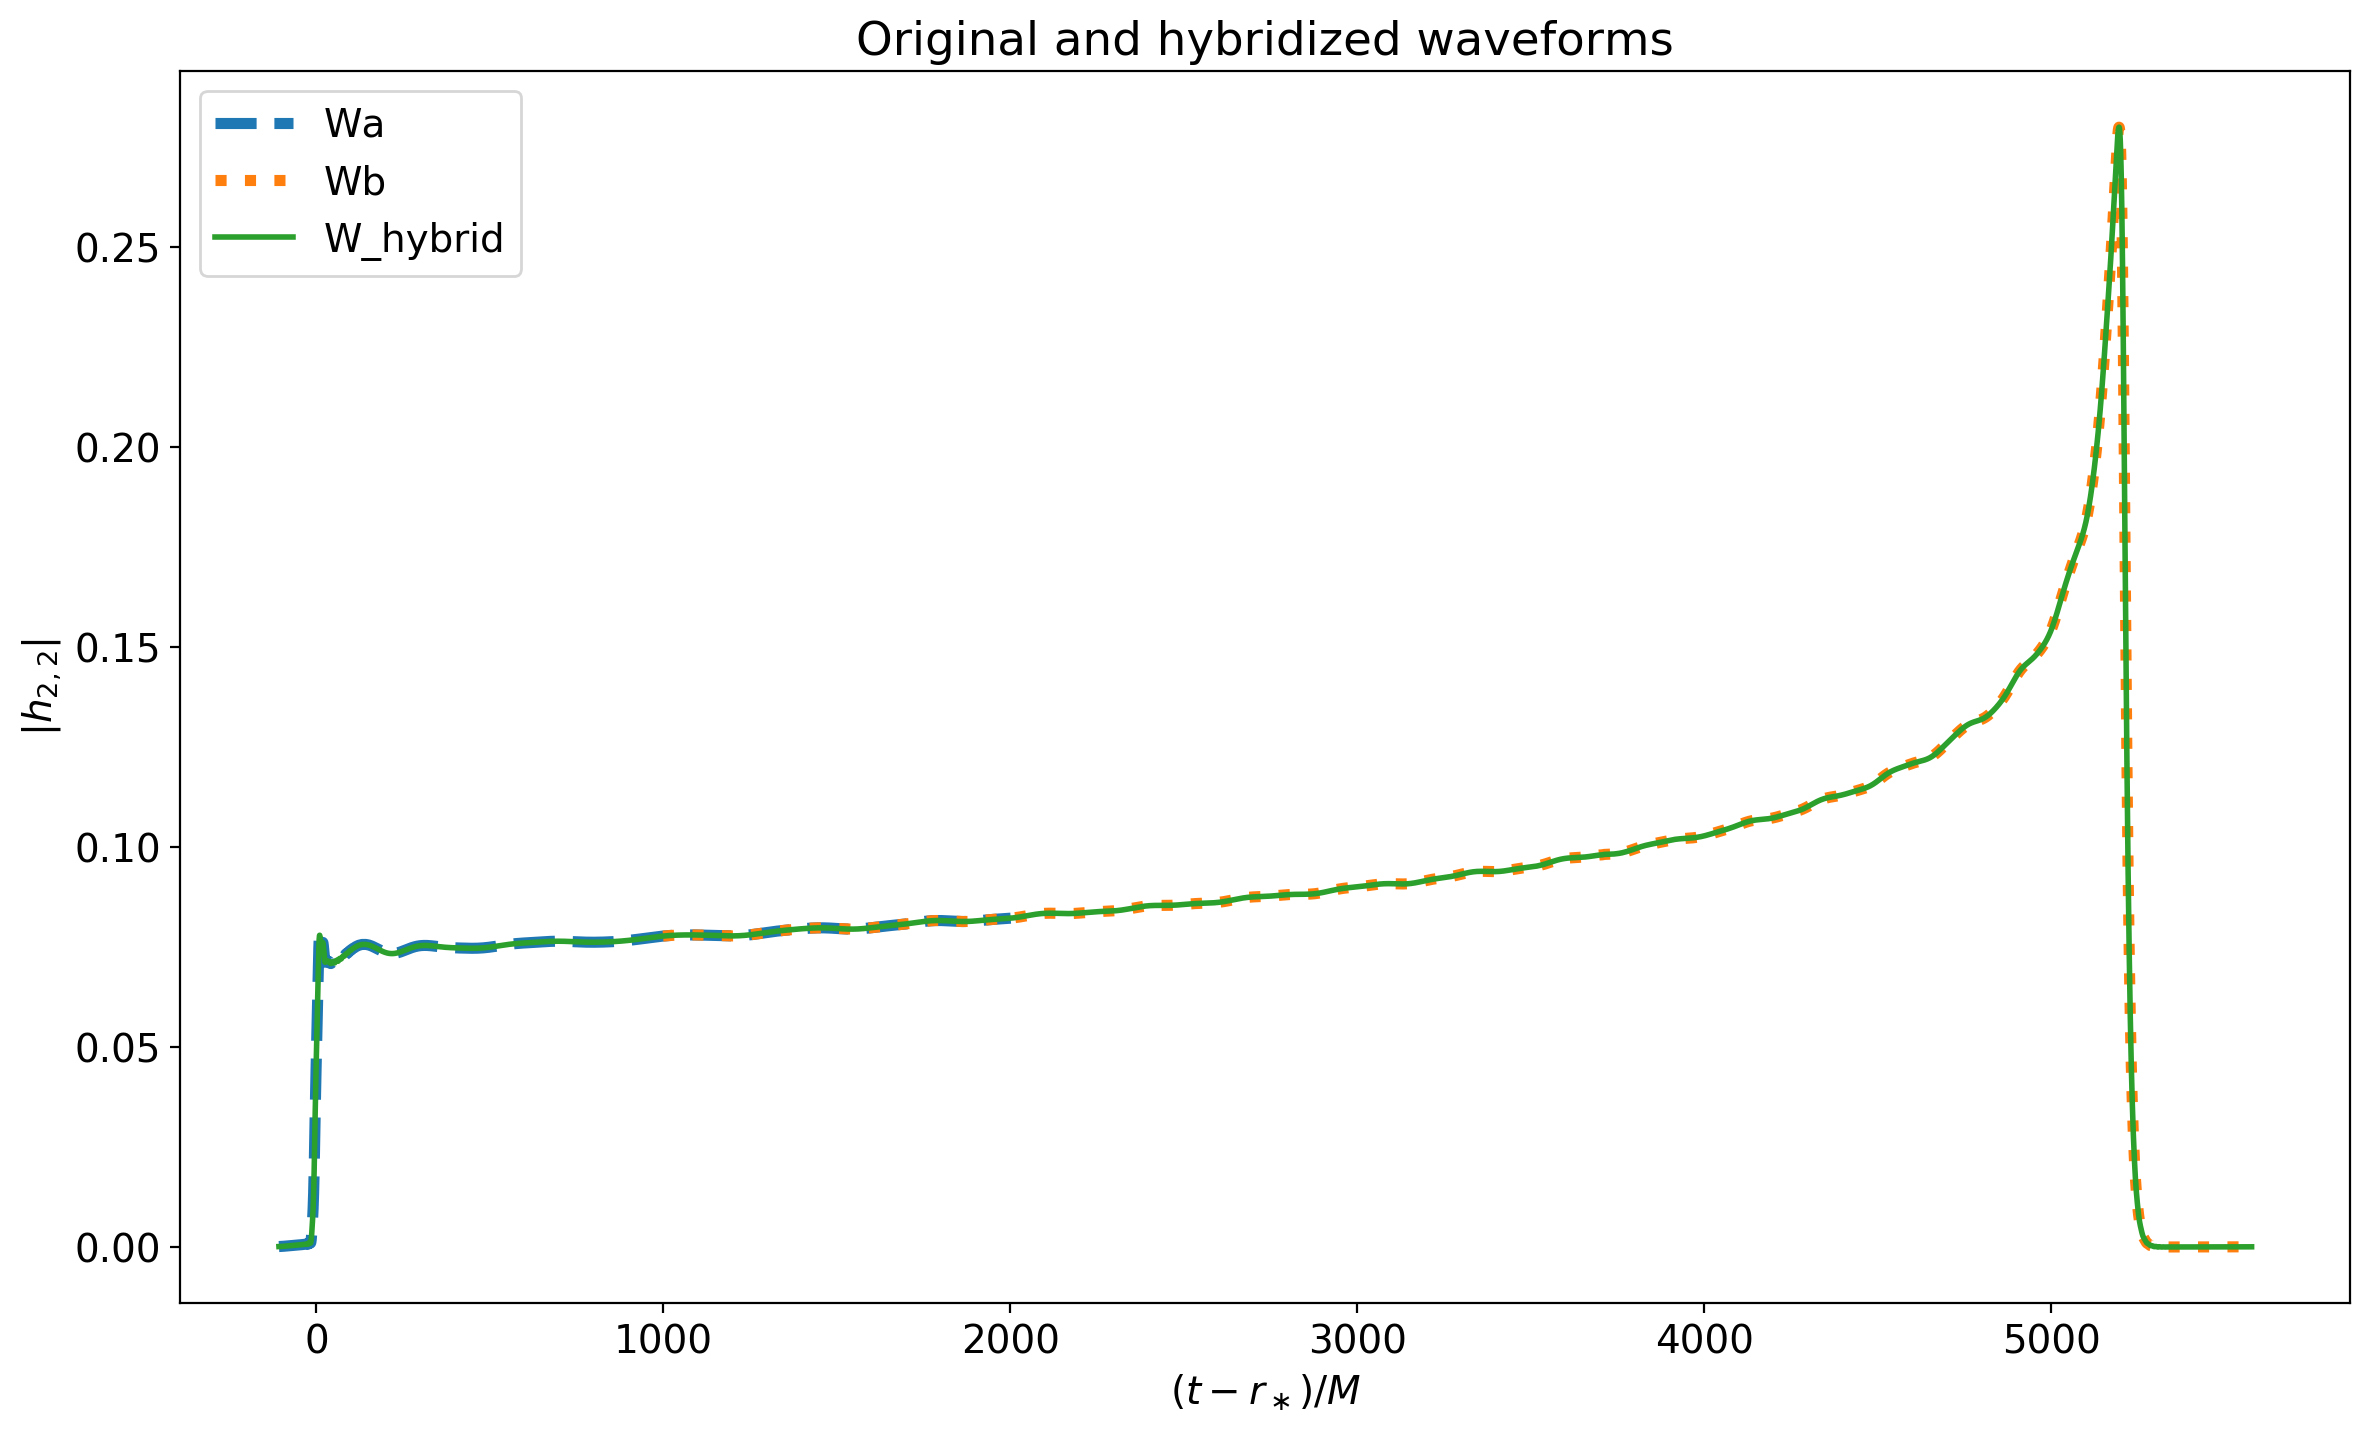

In [16]:
mode = 4  # This is the (2, 2) mode
plt.plot(Wa.T(), Wa.Abs(mode), label='Wa', lw=4, ls='dashed')
plt.plot(Wb.T(), Wb.Abs(mode), label='Wb', lw=4, ls='dotted')
plt.plot(W_hybrid.T(), W_hybrid.Abs(mode), label='W_hybrid', lw=2)
xlabel(r'$(t-r_\ast)/M$')
ylabel(r'$|h_{2,2}|$')
title('Original and hybridized waveforms')
plt.legend();

Note that `Wa` (the dashed line) only extends to ~2000, while `Wb` (the dotted line) only starts at ~1000, but the hybrid (skinny solid line) covers the whole range, and just interpolates between the other two.